# Modelling [categorical]

_________________________________________________________________________________

**Reference file:**
- pre_modelling_df.json: cleaned dataset before train-test split

**Problem:Predicting the affordability (quantiles)**

> insert specific questions

__________________________________________________________________________________

## 1.0 Loading file

In [1]:
#Import necessary libraries
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
import pydotplus
import lightgbm
import re

In [2]:
#Importing required packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from io import StringIO  
from IPython.display import Image  
from sklearn import tree, metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score, log_loss
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm

In [4]:
with open('../data/processed_data/pre_modelling_df.json', 'r') as file:
    data= json.load(file)
df=pd.DataFrame.from_dict(data)

In [5]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## 2.0 Train-test split

In [6]:
targeted_var = 'affordability'
excluded_features = ['product_name', 
                    #y values 
                     'pricepervol', 'affordability', 'affordability_bins',
                     'highlighted_ingr', 'ingr_list'
                    ]

In [7]:
X= df.drop(columns=excluded_features)
y= df[targeted_var]

*Encoding the target variable as numeric.*

In [33]:
enc= LabelEncoder()
y=enc.fit_transform(y)

In [34]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size= 0.3, random_state=12,
                                         #stratify if using affordability_bins (ranges)
                                            #stratify= y
                                         )

In [35]:
X_tr.shape, X_te.shape

((936, 175), (402, 175))

## 3.0 Feature engineering

In [10]:
#Create a copy of datasets
X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()

In [11]:
target_cols = ['num_likes', 'num_reviews']

for i in target_cols:
    # fit on training data column
    scaler = StandardScaler().fit(X_tr_scaled[[i]])
    
    # transform the training data column
    X_tr_scaled[i] = scaler.transform(X_tr_scaled[[i]])
    
    # transform the testing data column
    X_te_scaled[i] = scaler.transform(X_te_scaled[[i]])

<font color='red'> To confirm, I see some notebooks which transform the entire dataset. I assume we only have to transform certain features - i.e. those with varying ranges? 
    
also, if I used a standardscaler in my pipeline, then it would transform the entire dataset right? 
    
</font>

<font color= 'red'> 

  
On Normalisation....
</font>

## 4.0 Building initial / baseline models

<font color='red'> for now, used cv=5; to discuss if i should be using other cv methods i.e. repeatedkfold etc </font>

### Logistic Regression

In [12]:
logreg= LogisticRegression(solver='saga', random_state=123, max_iter=1000) 

In [36]:
logreg.fit(X_tr_scaled, y_tr)
y_tr_pred = logreg.predict(X_tr_scaled)
y_te_pred = logreg.predict(X_te_scaled)

**Evaluate model performance**

In [104]:
scores_list= ['accuracy', 'precision_weighted', 'precision_micro', 'f1_weighted', 'f1_micro']
def eval_model(fitted_model, X_train, y_train, num_cv=5, scores= scores_list, title='Model evaluation', show_train_scores=False):
    '''
    Uses cross-validation and returns a report of model performance metrics
    '''
    cv_results= cross_validate(fitted_model, X_train, y_train, cv=num_cv, scoring = scores, return_train_score=True)
    print(title)
    
    print('\nTest scores: (mean, SD)')
    for i in list(map(str, scores)):
        metric = 'test_'+i
        print(f' {str(i).title()}: \n ({round(cv_results[str(metric)].mean(),4)}, {round(cv_results[str(metric)].std(),4)})')
        
    if show_train_scores:
        print('\nTraining scores:')
        for i in list(map(str, scores)):
            metric = 'train_'+i
            print(f' {str(i).title()}: \n ({round(cv_results[str(metric)].mean(),4)}, {round(cv_results[str(metric)].std(),4)})')
        
    else:
        pass 
        
#     print(f' Accuracy (test) : \t %.4f' % logreg_cv['test_accuracy'].mean())
#     print(f' Accuracy (train): \t %.4f' % logreg_cv['train_accuracy'].mean())
#     #print(f' Precision (weighted): \t %.4f' % logreg_cv['test_precision_weighted'].mean())
#     print(f' Precision (micro): \t %.4f' % logreg_cv['test_precision_micro'].mean())
#     #print(f' F1 (weighted) : \t %.4f' % logreg_cv['test_f1_weighted'].mean())
#     print(f' F1 (micro) : \t \t %.4f' % logreg_cv['test_f1_micro'].mean())
    

In [105]:
eval_model(logreg, X_tr_scaled, y_tr, 5, scores_list, 'Logistic Regression - base (saga)', True)

Logistic Regression - base (saga)

Test scores: (mean, SD)
 Accuracy: 
 (0.6303, 0.0415)
 Precision_Weighted: 
 (0.6254, 0.0453)
 Precision_Micro: 
 (0.6303, 0.0415)
 F1_Weighted: 
 (0.6265, 0.0436)
 F1_Micro: 
 (0.6303, 0.0415)

Training scores:
 Accuracy: 
 (0.7853, 0.0096)
 Precision_Weighted: 
 (0.7843, 0.0101)
 Precision_Micro: 
 (0.7853, 0.0096)
 F1_Weighted: 
 (0.7845, 0.0098)
 F1_Micro: 
 (0.7853, 0.0096)


In [58]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    '''
    Returns a dictionary showing ROC-AUC score per class
    '''
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = round(roc_auc,4)

    return roc_auc_dict

In [59]:
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred)
print('Logistic regression model - base')
print(" ROC-AUC score per class")
print(' ', lr_roc_auc_multiclass)

print(' Classification report: \n', classification_report(y_te, y_te_pred))

Logistic regression model - base
 ROC-AUC score per class
  {0: 0.8652, 1: 0.6998, 2: 0.6541, 3: 0.8161}
 Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        98
           1       0.55      0.55      0.55       103
           2       0.54      0.46      0.50       111
           3       0.66      0.74      0.70        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.63      0.63      0.63       402



In [47]:
def plot_cm(fitted_model, X_test, y_test):
    '''
    Prints both normalized and non-normalized confusion matrix
    '''
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix, without normalization:", None),
                              ("Normalized confusion matrix:", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(fitted_model, X_test, y_test,
                                     display_labels=['¢','¢¢','¢¢¢','¢¢¢¢'], #used € since $ won't work
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

Logistic regression model - base (saga)
Confusion matrix, without normalization:
[[80 13  5  0]
 [17 58 21  7]
 [ 5 26 51 29]
 [ 2  6 17 65]]
Normalized confusion matrix:
[[0.82 0.13 0.05 0.  ]
 [0.17 0.56 0.2  0.07]
 [0.05 0.23 0.46 0.26]
 [0.02 0.07 0.19 0.72]]


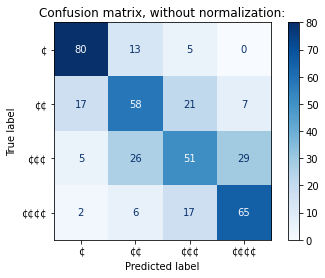

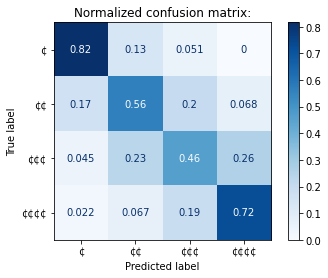

In [48]:
print('Logistic regression model - base (saga)')
plot_cm(logreg, X_te_scaled, y_te)

*The initial logistic regression model has high accuracy for the cheapest and the most expensive classes but less so on the mid-priced products.*

<font color='red'> Logistic regression in multi-class predictions 

- to confirm - it cant predict probabilities for multiclass?
- log loss only 
- can we do ROC on multiclass - didnt do predict proba - so did not do ROC here

</font> 

#### Tuning the logistic regression model

From the documentation...

For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
- newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
- ‘liblinear’ and ‘saga’ also handle L1 penalty
- ‘saga’ also supports ‘elasticnet’ penalty

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

In [51]:
#Use GridSearch, optimizing for best accuracy
logreg_tuned=LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga'] #chose the ones which can handle multinomial loss
penalty = ['l2', 'l1', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg_tuned, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_tr_scaled, y_tr)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#store best parameters
logreg_opt_parameters = grid_result.best_params_

Best: 0.647739 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.630955 (0.049961) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.631018 (0.052038) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.634255 (0.053050) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.621096 (0.056542) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.620385 (0.056505) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.647739 (0.051202

**Building another Logistic Regression model using tuned hyperparameters**

In [52]:
logreg_opt_parameters

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

In [53]:
logreg_opt = LogisticRegression(solver='newton-cg', penalty='l2', C=10)
logreg_opt.fit(X_tr_scaled, y_tr)
y_tr_pred = logreg_opt.predict(X_tr_scaled)
y_te_pred = logreg_opt.predict(X_te_scaled)

In [57]:
eval_model(logreg_opt, X_tr_scaled, y_tr, 5, scores_list, 'Logistic regression model - tuned parameters', True)

Logistic regression model - tuned parameters

Test scores:
 Accuracy: 0.6314
 Precision_Weighted: 0.6292
 Precision_Micro: 0.6314
 F1_Weighted: 0.6293
 F1_Micro: 0.6314

Training scores:
 Accuracy: 0.8459
 Precision_Weighted: 0.8459
 Precision_Micro: 0.8459
 F1_Weighted: 0.8457
 F1_Micro: 0.8459


In [60]:
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred)
print('Logistic regression model - tuned parameters')
print(" ROC-AUC score per class")
print(' ', lr_roc_auc_multiclass)
print(' Classification report: \n', classification_report(y_te, y_te_pred))

Logistic regression model - tuned parameters
 ROC-AUC score per class
  {0: 0.8652, 1: 0.6998, 2: 0.6541, 3: 0.8161}
 Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        98
           1       0.55      0.55      0.55       103
           2       0.54      0.46      0.50       111
           3       0.66      0.74      0.70        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.63      0.63      0.63       402



*Tuning has improved the accuracy of the predictions but the improvement is immaterial.*

#### Insights from the model

<font color='red'> TBU with comment on which features were ranked highly etc
    
</font>

> Insert comments on which features were highly ranked

> run model again after feature selection? 

*Feature selection*

*Retraining the model with less features*

In [179]:
X_tr_sc_select = X_tr_scaled.loc[:, important_feature_names].copy()
X_te_sc_select = X_te_scaled.loc[:, important_feature_names].copy()

In [183]:
logreg_select = LogisticRegression(
    solver='newton-cg', penalty='l2', C=10 
)

In [184]:
logreg_select.fit(X_tr_sc_select, y_tr)

y_tr_pred_lgs = logreg_select.predict(X_tr_sc_select)
y_te_pred_lgs = logreg_select.predict(X_te_sc_select)

In [185]:
accuracy_score(y_te, y_te_pred_lgs)

0.6119402985074627

In [188]:
eval_model(logreg_select, X_tr_sc_select, y_tr, 5, scores_list, 'Logistic Regression - selected features, tuned parameters', True)

Logistic Regression - selected features, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6057, 0.0269)
 Precision_Weighted: 
 (0.6094, 0.0333)
 Precision_Micro: 
 (0.6057, 0.0269)
 F1_Weighted: 
 (0.6054, 0.0294)
 F1_Micro: 
 (0.6057, 0.0269)

Training scores:
 Accuracy: 
 (0.6744, 0.0074)
 Precision_Weighted: 
 (0.6763, 0.0082)
 Precision_Micro: 
 (0.6744, 0.0074)
 F1_Weighted: 
 (0.6751, 0.0077)
 F1_Micro: 
 (0.6744, 0.0074)


In [190]:
#Use GridSearch, optimizing for best accuracy
logreg_tuned2=LogisticRegression(max_iter=1000, random_state=13)
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga'] #chose the ones which can handle multinomial loss
penalty = ['l2', 'l1', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg_tuned2, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_tr_sc_select, y_tr)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#store best parameters
logreg_opt_parameters2 = grid_result.best_params_

Best: 0.612171 using {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
0.607874 (0.045892) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.607874 (0.045892) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.608225 (0.045601) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.608938 (0.045524) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.609651 (0.045948) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.608240 (0.046636) wi

In [192]:
logreg_opt_parameters2

{'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}

______________________

*Regularisation
L1, l2 etc - for numeric

Normalisation

SMOTE - for imbalanced?*

*what are the top predictor values *

Regularization for logistic regression

PCA???

Plotting ROC for multilabel [https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings]

____________________

### Support Vector Machines (SVM)

In [61]:
#Initiate SVM models with different kernels; used 'ovo' for multiclass strategy
linear = svm.SVC(kernel='linear', decision_function_shape='ovo').fit(X_tr_scaled, y_tr)
rbf = svm.SVC(kernel='rbf', decision_function_shape='ovo').fit(X_tr_scaled, y_tr)
#rbf = svm.SVC(kernel='rf', gamma=1, C=1, decision_function_shape='ovo').fit(X_tr_scaled, y_tr)
poly = svm.SVC(kernel='poly', degree=3, decision_function_shape='ovo').fit(X_tr_scaled, y_tr)
sig = svm.SVC(kernel='sigmoid', decision_function_shape='ovo').fit(X_tr_scaled, y_tr)

In [62]:
y_te_pred_lin = linear.predict(X_te_scaled)
y_te_pred_poly = poly.predict(X_te_scaled)
y_te_pred_rbf = rbf.predict(X_te_scaled)
y_te_pred_sig = sig.predict(X_te_scaled)

In [63]:
#Check initial accuracy scores
print('Support vector machine - base')
print(f' Accuracy Linear Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_lin))
print(f' Accuracy Polynomial Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_poly))
print(f' Accuracy Radial Basis Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_rbf))
print(f' Accuracy Sigmoid Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_sig))

Support vector machine - base
 Accuracy Linear Kernel: 	 0.6443
 Accuracy Polynomial Kernel: 	 0.6318
 Accuracy Radial Basis Kernel: 	 0.6269
 Accuracy Sigmoid Kernel: 	 0.5846


*Linear kernel performs best. As the scores are not significantly different, let's check the cross-validation scores.*

In [64]:
#To evaluate with cross-validation
eval_model(linear, X_tr_scaled, y_tr, 5, scores_list, 'SVM: Linear kernel - base')

SVM: Linear kernel - base

Test scores:
 Accuracy: 0.6314
 Precision_Weighted: 0.6318
 Precision_Micro: 0.6314
 F1_Weighted: 0.6301
 F1_Micro: 0.6314


In [65]:
eval_model(poly, X_tr_scaled, y_tr, 5, scores_list, 'SVM: Polynomial kernel (3) - base')

SVM: Polynomial kernel (3) - base

Test scores:
 Accuracy: 0.5961
 Precision_Weighted: 0.6055
 Precision_Micro: 0.5961
 F1_Weighted: 0.5967
 F1_Micro: 0.5961


In [66]:
eval_model(poly, X_tr_scaled, y_tr, 5, scores_list, 'SVM: Radial basis kernel - base')

SVM: Radial basis kernel - base

Test scores:
 Accuracy: 0.5961
 Precision_Weighted: 0.6055
 Precision_Micro: 0.5961
 F1_Weighted: 0.5967
 F1_Micro: 0.5961


In [67]:
eval_model(sig, X_tr_scaled, y_tr, 5, scores_list, 'SVM: Sigmoid kernel - base')

SVM: Sigmoid kernel - base

Test scores:
 Accuracy: 0.563
 Precision_Weighted: 0.5623
 Precision_Micro: 0.563
 F1_Weighted: 0.5582
 F1_Micro: 0.563


*With cross-validation, the gap between the model performance widens, confirming that the linear kernel SVM is superior to the others*

In [68]:
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred_lin)
print('SVM: Linear kernel - base')
print(" ROC-AUC score per class")
print(' ', lr_roc_auc_multiclass)

print(' Classification report: \n', classification_report(y_te, y_te_pred_lin))

SVM: Linear kernel - base
 ROC-AUC score per class
  {0: 0.8738, 1: 0.7195, 2: 0.676, 3: 0.7932}
 Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        98
           1       0.60      0.57      0.58       103
           2       0.55      0.51      0.53       111
           3       0.66      0.69      0.67        90

    accuracy                           0.64       402
   macro avg       0.64      0.65      0.65       402
weighted avg       0.64      0.64      0.64       402



#### Insights from the model: 

> TBC
>

### Decision Tree Classifier

In [69]:
tree_criterion = 'entropy' #gini or entropy
tree_depth = None

In [70]:
dtree = DecisionTreeClassifier(criterion=tree_criterion, max_depth = tree_depth, random_state=123)
dtree.fit(X_tr_scaled, y_tr)

DecisionTreeClassifier(criterion='entropy', random_state=123)

In [71]:
y_tr_pred = dtree.predict(X_tr_scaled)
y_te_pred = dtree.predict(X_te_scaled)

In [75]:
def decision_tree(X_train, X_test, y_train, y_test, tree_criterion, tree_depth=None, disp_cm=0):
    '''
    Runs a decision tree criterion based on inputs
    Returns evaluation metrics
    '''
    dtree = DecisionTreeClassifier(criterion=tree_criterion, max_depth = tree_depth, random_state=123)
    dtree.fit(X_train, y_train)
    
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    
    print(f'Decision Tree model - {tree_criterion} criterion, max depth: {tree_depth}')
    print(f'Accuracy (train): \t %.4f' %metrics.accuracy_score(y_train ,y_train_pred))
    print(f'Accuracy (test): \t %.4f' %metrics.accuracy_score(y_test ,y_test_pred))
    print(f'Balanced accuracy:\t %.4f' %metrics.balanced_accuracy_score(y_test,y_test_pred))
    print('Classification report: \n', classification_report(y_test, y_test_pred))
    
    if disp_cm>0:
        np.set_printoptions(precision=2)
        titles_options = [("Confusion matrix, without normalization:", None),
                          ("Normalized confusion matrix:", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(dtree, X_test, y_test,
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)

        plt.show()

**Modelling without maximum tree depths**

In [76]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'entropy', None)

Decision Tree model - entropy criterion, max depth: None
Accuracy (train): 	 1.0000
Accuracy (test): 	 0.5249
Balanced accuracy:	 0.5286
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.73      0.72        98
           1       0.40      0.34      0.37       103
           2       0.42      0.50      0.45       111
           3       0.60      0.54      0.57        90

    accuracy                           0.52       402
   macro avg       0.53      0.53      0.53       402
weighted avg       0.52      0.52      0.52       402



In [77]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', None)

Decision Tree model - gini criterion, max depth: None
Accuracy (train): 	 1.0000
Accuracy (test): 	 0.5075
Balanced accuracy:	 0.5141
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.72      0.71        98
           1       0.38      0.46      0.41       103
           2       0.40      0.34      0.37       111
           3       0.61      0.53      0.57        90

    accuracy                           0.51       402
   macro avg       0.52      0.51      0.51       402
weighted avg       0.51      0.51      0.51       402



*Observations:*
- Entropy model performs slightly better than using the gini coefficient as criterion for the decision tree model.
- In both models: 
    - Without a limit on the tree depth, the model overfits entirely, as expected.
    - Better prediction for the cheapest and most expensive segments (0, 3).

**Modelling with limitation on tree depth**

In order to avoid overfitting and improve generalisability of the model, we will impose a max depth on the trees built.

In [78]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'entropy', 10)

Decision Tree model - entropy criterion, max depth: 10
Accuracy (train): 	 0.6987
Accuracy (test): 	 0.5622
Balanced accuracy:	 0.5626
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.72      0.77        98
           1       0.47      0.34      0.40       103
           2       0.41      0.63      0.50       111
           3       0.69      0.56      0.62        90

    accuracy                           0.56       402
   macro avg       0.60      0.56      0.57       402
weighted avg       0.59      0.56      0.56       402



In [79]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', 10)

Decision Tree model - gini criterion, max depth: 10
Accuracy (train): 	 0.7041
Accuracy (test): 	 0.5796
Balanced accuracy:	 0.5800
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80        98
           1       0.49      0.42      0.45       103
           2       0.42      0.59      0.49       111
           3       0.72      0.52      0.61        90

    accuracy                           0.58       402
   macro avg       0.61      0.58      0.59       402
weighted avg       0.61      0.58      0.58       402



*Observations*
- With the shallower tree, the accuracy on the training set decreases as expected but the generalisability (i.e. performance on unseen data / test set) improves for both models.
- We observe better predictive ability for all classes.
- Without imposing a tree depth, entropy model performed better. However, as shown above, the tree model performance varies depending on the depth used. This will be explored further.

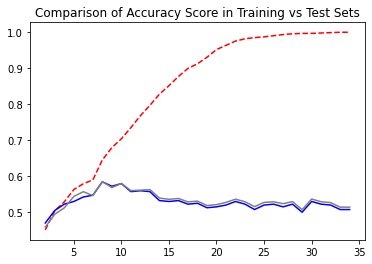

In [80]:
depths = [n for n in range(2, 35)]
training_score= []
testing_score=[]
b_testing_score=[]

for val in depths: 
    dtree = DecisionTreeClassifier(criterion='gini', max_depth = val, random_state=123)
    dtree.fit(X_tr_scaled, y_tr)
    
    y_train_pred = dtree.predict(X_tr_scaled)
    y_test_pred = dtree.predict(X_te_scaled)
    
    training_score.append(metrics.accuracy_score(y_tr ,y_train_pred))
    testing_score.append(metrics.accuracy_score(y_te ,y_test_pred))
    b_testing_score.append(metrics.balanced_accuracy_score(y_te,y_test_pred))

plt.plot(depths, training_score, linestyle='dashed', color='red')
plt.plot(depths, testing_score, linestyle='solid', color='blue')
plt.plot(depths, b_testing_score, linestyle='solid', color='grey')
plt.title('Comparison of Accuracy Score in Training vs Test Sets')
plt.show()

In [81]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', 8)

Decision Tree model - gini criterion, max depth: 8
Accuracy (train): 	 0.6453
Accuracy (test): 	 0.5846
Balanced accuracy:	 0.5850
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.77      0.82        98
           1       0.61      0.24      0.35       103
           2       0.42      0.72      0.53       111
           3       0.63      0.61      0.62        90

    accuracy                           0.58       402
   macro avg       0.64      0.58      0.58       402
weighted avg       0.63      0.58      0.58       402



*Observations*
- Based on the visualisation above, the better model uses a gini criterion with a max depth of 8 layers. 
- Performance-wise, however, the lift is not significant. 

In [82]:
dtree2 = DecisionTreeClassifier(criterion='gini', max_depth = 8, random_state=123)
dtree2.fit(X_tr_scaled, y_tr)

DecisionTreeClassifier(max_depth=8, random_state=123)

In [83]:
y_tr_pred = dtree.predict(X_tr_scaled)
y_te_pred = dtree.predict(X_te_scaled)

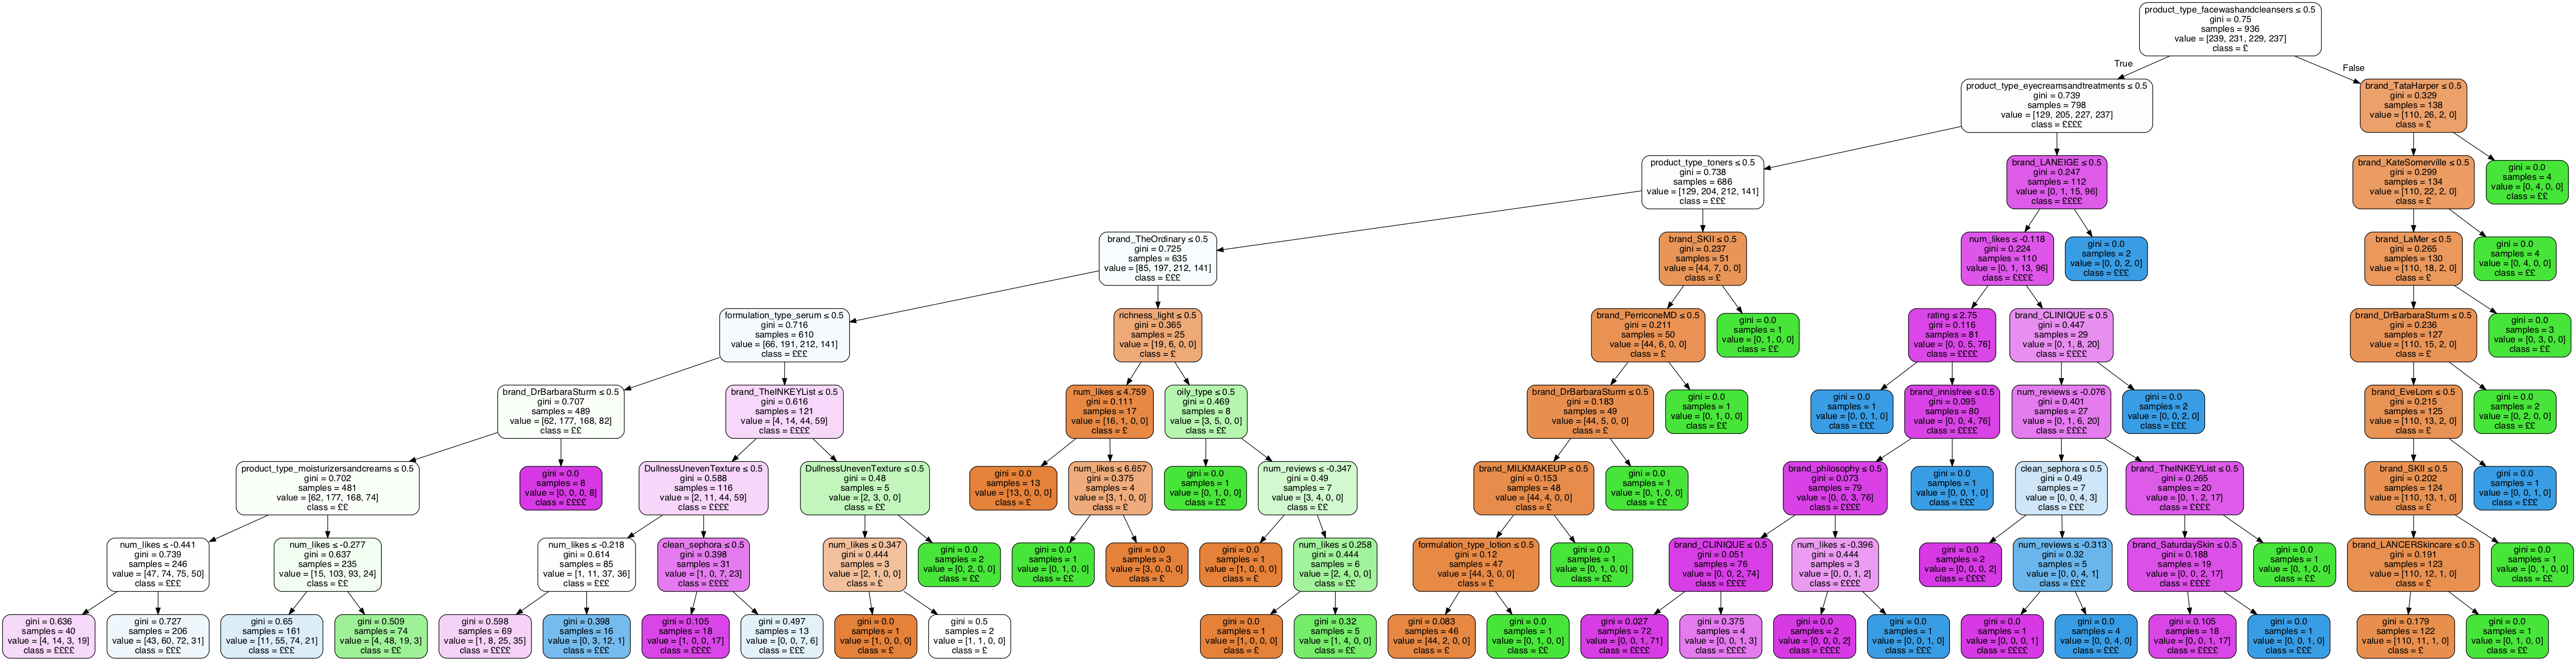

In [84]:
dot_data = StringIO()

tree.export_graphviz(dtree2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=X_tr_scaled.columns,
                class_names = ['£','££', '£££', '££££']
                ) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_pdf('tree.pdf')
Image(graph.create_png())

#### Insights from the model

> Product type, number of likes, number of reviews, clean@sephora, dullness, brands, richness of formulation

## 3.1 Ensemble models

### RandomForest Model

In [86]:
#First try the default settings for RF
rf = RandomForestClassifier(random_state = 123, n_jobs=-1)

In [88]:
rf.fit(X_tr_scaled, y_tr)

RandomForestClassifier(n_jobs=-1, random_state=123)

In [89]:
y_tr_pred= rf.predict(X_tr_scaled)
y_te_pred= rf.predict(X_te_scaled)

In [106]:
eval_model(rf, X_tr_scaled, y_tr, 5, scores_list, 'RandomForest model - scaled, base', True)

RandomForest model - base

Test scores: (mean, SD)
 Accuracy: 
 (0.6165, 0.0315)
 Precision_Weighted: 
 (0.6115, 0.0322)
 Precision_Micro: 
 (0.6165, 0.0315)
 F1_Weighted: 
 (0.6107, 0.0325)
 F1_Micro: 
 (0.6165, 0.0315)

Training scores:
 Accuracy: 
 (1.0, 0.0)
 Precision_Weighted: 
 (1.0, 0.0)
 Precision_Micro: 
 (1.0, 0.0)
 F1_Weighted: 
 (1.0, 0.0)
 F1_Micro: 
 (1.0, 0.0)


*Using the default parameters, it will overfit as we did not set a max depth.*

In [109]:
rf_criterion='entropy' #default: gini
estimators= 100
rf_depth=6
rf2= RandomForestClassifier(n_estimators = estimators, criterion = rf_criterion,   
                            max_depth= rf_depth, random_state = 123, n_jobs=-1)

In [107]:
#Since RF is not distance based, we can try non-scaled 
eval_model(rf2, X_tr, y_tr, 5, scores_list, 'RandomForest model - unscaled, max depth imposed', True)

RandomForest model not scaled- with max depth

Test scores: (mean, SD)
 Accuracy: 
 (0.6004, 0.0396)
 Precision_Weighted: 
 (0.5888, 0.0428)
 Precision_Micro: 
 (0.6004, 0.0396)
 F1_Weighted: 
 (0.5902, 0.042)
 F1_Micro: 
 (0.6004, 0.0396)

Training scores:
 Accuracy: 
 (0.7676, 0.0102)
 Precision_Weighted: 
 (0.7668, 0.0108)
 Precision_Micro: 
 (0.7676, 0.0102)
 F1_Weighted: 
 (0.7648, 0.0101)
 F1_Micro: 
 (0.7676, 0.0102)


In [108]:
eval_model(rf2, X_tr_scaled, y_tr, 5, scores_list, 'RandomForest model - scaled, with max depth', True)

RandomForest model - with max depth

Test scores: (mean, SD)
 Accuracy: 
 (0.5994, 0.039)
 Precision_Weighted: 
 (0.5876, 0.0421)
 Precision_Micro: 
 (0.5994, 0.039)
 F1_Weighted: 
 (0.589, 0.0412)
 F1_Micro: 
 (0.5994, 0.039)

Training scores:
 Accuracy: 
 (0.7674, 0.0103)
 Precision_Weighted: 
 (0.7666, 0.0108)
 Precision_Micro: 
 (0.7674, 0.0103)
 F1_Weighted: 
 (0.7645, 0.0101)
 F1_Micro: 
 (0.7674, 0.0103)


*By imposing a maximum depth of 6 layers, the performance on the test set has reduced slightly. However, this is preferrable to overfitting. To optimise the model further, we will use RandomizedSearch or GridSearch to retrieve hyperparameter values which can optimize predictive accuracy of RF.*

In [115]:
rf2.fit(X_tr, y_tr)
y_tr_pred= rf2.predict(X_te)
print('Classification report: \n', classification_report(y_te, y_te_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.81      0.75        98
           1       0.54      0.47      0.50       103
           2       0.54      0.45      0.49       111
           3       0.60      0.72      0.66        90

    accuracy                           0.60       402
   macro avg       0.60      0.61      0.60       402
weighted avg       0.59      0.60      0.59       402



In [112]:
plot_cm(rf2, X_te, y_te)

Confusion matrix, without normalization:
[[79 14  5  0]
 [24 48 22  9]
 [ 6 21 50 34]
 [ 3  6 16 65]]
Normalized confusion matrix:
[[0.81 0.14 0.05 0.  ]
 [0.23 0.47 0.21 0.09]
 [0.05 0.19 0.45 0.31]
 [0.03 0.07 0.18 0.72]]


**Visualizing the tree**

*Which feature are predictive of pricing?*

In [116]:
estimator = rf2.estimators_[5]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_tr_scaled.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

30


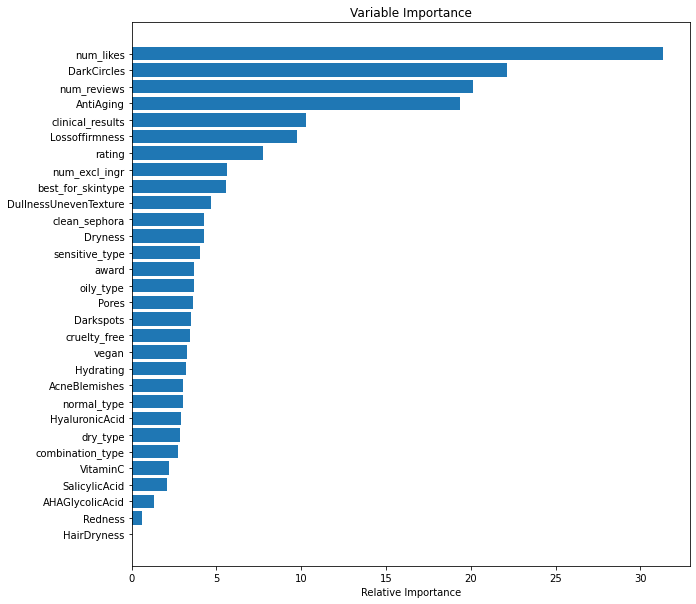

In [121]:
feature_importances = rf2.feature_importances_
# make importances relative to max importance
feature_importances = 100.0 * (feature_importances / feature_importances.max())[:30]
sorted_idx = np.argsort(feature_importances)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<font color='red'> Note: feature importance order changed when x_tr_scaled is used </font>

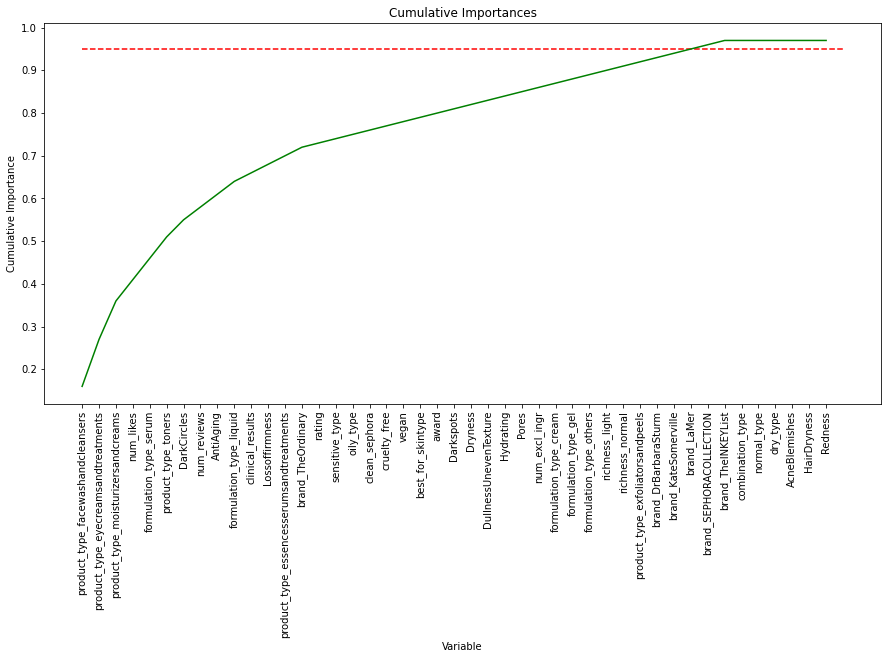

In [153]:
feat_list =[(feature, round(feature_importance, 2))
    for feature, feature_importance in zip(X_tr.columns, rf2.feature_importances_.tolist())]
feat_list = sorted(feat_list, key = lambda x:x[1], reverse=True)[:45]
x_values = list(range(45))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feat_list]
sorted_features = [importance[0] for importance in feat_list]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.figure(figsize=(15,7))
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Importances');
plt.show()

In [158]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feat_list[0:38]]
important_feature_names

['product_type_facewashandcleansers',
 'product_type_eyecreamsandtreatments',
 'product_type_moisturizersandcreams',
 'num_likes',
 'formulation_type_serum',
 'product_type_toners',
 'DarkCircles',
 'num_reviews',
 'AntiAging',
 'formulation_type_liquid',
 'clinical_results',
 'Lossoffirmness',
 'product_type_essencesserumsandtreatments',
 'brand_TheOrdinary',
 'rating',
 'sensitive_type',
 'oily_type',
 'clean_sephora',
 'cruelty_free',
 'vegan',
 'best_for_skintype',
 'award',
 'Darkspots',
 'Dryness',
 'DullnessUnevenTexture',
 'Hydrating',
 'Pores',
 'num_excl_ingr',
 'formulation_type_cream',
 'formulation_type_gel',
 'formulation_type_others',
 'richness_light',
 'richness_normal',
 'product_type_exfoliatorsandpeels',
 'brand_DrBarbaraSturm',
 'brand_KateSomerville',
 'brand_LaMer',
 'brand_SEPHORACOLLECTION']

*Try building out a new model based only on these features*

In [162]:
X_tr_select = X_tr.loc[:, important_feature_names].copy()
X_te_select = X_te.loc[:, important_feature_names].copy()

**Optimize the RandomForest model using GridSearch**

Selected parameters to tune for RF:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

Leveraging on Bayesian Optimization

<font color='red'> still figuring this out!!! </font>

In [ ]:
def lgb_eval(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf):
    '''
    
    
    '''
#     params = {
#         'n_estimators': int(n_estimators),
#         'max_features': int(max_features),
#         'max_depth': int(max_depth),
#         'min_samples_split': int(min_samples_split),
#         'min_samples_leaf': int(min_samples_leaf)
#     }
    
    rf_eval= RandomForestClassifier(n_estimators=int(n_estimators),
                                    max_features= int(max_features),
                                    max_depth= int(max_depth),
                                    min_samples_split= int(min_samples_split),
                                    min_samples_leaf=int(min_samples_leaf))
    rf_eval.fit(X_tr_scaled, y_tr)
    retrun [xxx] 
    lgtrain = lightgbm.Dataset(X_tr_scaled, y_tr)
    cv_result = lightgbm.cv(params,
                       lgtrain,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['auc-mean'][-1]

In [ ]:
lgbBO = BayesianOptimization(lgb_eval, {'n_estimators': (100, 2000),
                                        'max_features': (5, 100),
                                        'max_depth': (10, 120),
                                        'min_samples_split': (20, 100),
                                        'min_samples_leaf': (30, 90)})

lgbBO.maximize(n_iter=10, init_points=2)

In [ ]:
lgbBO.max['params']

In [ ]:
eval_model(rf_opt, X_tr, y_tr, 5, scores_list, 'RandomForest model - with max depth', True)

In [ ]:
eval_model(rf2, X_tr, y_tr, 5, scores_list, 'RandomForest model - with max depth', True)

______________________

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 3000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#min_samples_split = [60, 75, 90]
#min_samples_leaf = [1, 3, 5, 7]
#min_samples_split = [60, 75, 90]
#min_samples_leaf = [1, 3, 5, 7]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_search = RandomForestClassifier(random_state = 123, n_jobs=-1)
rf_cv= RandomizedSearchCV(rf_search, random_grid, cv=5, n_iter=5)
rf_cv.fit(X_tr_scaled,y_tr)

In [ ]:
rf_cv.best_score_

In [ ]:
rf_cv.best_params_

In [ ]:
rf_opt= RandomForestClassifier(n_estimators=1112, min_samples_split= 90, min_samples_leaf= 3,
                               max_features='sqrt', max_depth= 50, bootstrap=False, random_state=123)

In [ ]:
rf_opt= RandomForestClassifier(n_estimators=1112, min_samples_split= 90, min_samples_leaf= 3,
                               max_features='sqrt', max_depth= 50, bootstrap=False, random_state=123)

In [ ]:
eval_model(rf_opt, X_tr_scaled, y_tr, 5, scores_list, 'RandomForest - tuned hyperparameters', True)

In [ ]:
#Use cross validation 
scores = ['accuracy', 'precision_weighted', 'precision_micro', 'f1_weighted', 'f1_micro']
rf_opt_cv= cross_validate(rf_opt, X_tr_scaled, y_tr, cv=5, scoring=scores, return_train_score=True)

In [ ]:
print('RandomForest - cross-validated, tuned hyperparameters')
print(f'Accuracy : \t \t %.4f' % rf_opt_cv['test_accuracy'].mean())
print(f'Precision (weighted): \t %.4f' % rf_opt_cv['test_precision_weighted'].mean())
print(f'Precision (micro): \t %.4f' % rf_opt_cv['test_precision_micro'].mean())
print(f'F1 (weighted) : \t %.4f' % rf_opt_cv['test_f1_weighted'].mean())
print(f'F1 (micro) : \t \t %.4f' % rf_opt_cv['test_f1_micro'].mean())

In [ ]:
rf_opt.fit(X_te_scaled, y_te)

In [ ]:
print('RandomForest model -  tuned hyperparameters ')
print(f' Accuracy: \t \t %.4f' % accuracy_score(y_te, y_te_pred))
print(f' Balanced accuracy:\t %.4f' %metrics.balanced_accuracy_score(y_te,y_te_pred))
print(f' F1-score (weighted): \t %.4f' % f1_score(y_te, y_te_pred, average='weighted'))
print(f' F1-score (micro): \t %.4f' % f1_score(y_te, y_te_pred, average='micro'))
print(f' Precision (micro): \t %.4f' % precision_score(y_te, y_te_pred, average='micro'))

In [ ]:
print('Classification report: \n', classification_report(y_te, y_te_pred))

In [ ]:
plot_cm(rf_opt, X_te_scaled, y_te)

### XGBoost

### 2.1 Mean as predictor

In [ ]:
method= 'median' #can also try other methods: median, most frequent/mode

In [ ]:
dumb_reg = DummyRegressor(strategy=method) 
dumb_reg.fit(X_tr_scaled, y_tr)
dumb_reg.constant_

In [ ]:
y_tr_pred = dumb_reg.predict(X_tr_scaled)

In [ ]:
#Model will predict the same value everytime
y_te_pred = float(dumb_reg.constant_) * np.ones(len(y_te))

In [ ]:
print(f'Assessing the model performance using a {method} baseline')
print('\n')
print('R2 score')
print(f'Training set: {round(r2_score(y_tr, y_tr_pred),4)}')
print(f'Testing set: {round(r2_score(y_te, y_te_pred),4)}')
print('\n')
print('Mean Absolute Error (MAE)')
print(f'Training set: {round(mean_absolute_error(y_tr, y_tr_pred),4)}')
print(f'Testing set: {round(mean_absolute_error(y_te, y_te_pred),4)}')
print('\n')
print('Root Mean Squared Error (RMSE)')
print(f'Training set: {round(np.sqrt(mean_squared_error(y_tr, y_tr_pred)),4)}')
print(f'Testing set: {round(np.sqrt(mean_squared_error(y_te, y_te_pred)),4)}')

**[Comment]**